In [ ]:
import numpy as np
import pandas as pd
from google.colab import files
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy.stats import kurtosis
from scipy.stats import skew
from scipy.stats import shapiro
from scipy.stats import normaltest
import seaborn as sns
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from xgboost.sklearn import XGBClassifier
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


### решить задачу классификации на предложенном датасете с использованием Boosting моделей.

Датасет: https://www.kaggle.com/uciml/red-wine-quality-cortez-et-al-2009


## Вспомогательные функции

In [ ]:
## Просмотр данных
def prosmotr(data):
  pd.set_option('display.max_columns', 100) #Размеры таблицы
  pd.set_option('display.max_rows', 100)
  pd.set_option('precision', 2) #Регулируем количество знаков после запятой:
  print('~~~~Содержание данных~~~~\n', data.head())
  print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
  print('~~~Размеры данных~~~\n', data.shape)
  print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
  print('~~~Названия колонок~~~\n', data.columns)
  print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
  print('~~~Информация о данных~~~\n')
  print(data.info())
  print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
  print('~~~Наличие пропусков в данных~~~\n', data.isna().sum())
  print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
  print('~~~Количество типов в данных~~~')
  print(data.dtypes.value_counts())
  print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
  kateg = list(data.select_dtypes(include=['object']).columns) # Делаем список категориальных данных
  print('~~~Категориальные данные~~~~')
  print(kateg)
  print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
  chislov_float = list(data.select_dtypes(include=['float64'])) #Делаем список числовых данных float
  print('~~~Числове данные float~~~~')
  print(chislov_float)
  print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
  chislov_int = list(data.select_dtypes(include=['int64'])) #Делаем список числовых данных int
  print('~~~Числове данные int~~~~')
  print(chislov_int)
  print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
  print('~~~Основные статистические характеристики данных по каждому числовому признаку (типы int64)~~~\n', data.describe(include=['int64']))
  print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
  print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
  print('~~~Основные статистические характеристики данных по каждому числовому признаку (типы float64)~~~\n', data.describe(include=['float64']))
  print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
  

In [ ]:
## Анализ данных
def analyze(data):
  num = data.columns
  for i in num:
    print(i.title())
    print('~~~~~~~~~~~~~~~~~~~~~~~~~\n')
    print("mean : ", np.mean(data[i]))
    print("var  : ", np.var(data[i]))
    print("skew : ", skew(data[i]))
    print("kurt : ", kurtosis(data[i]))
    print("shapiro : ", shapiro(data[i]))
    print("normaltest : ", normaltest(data[i]))
    print('~~~~~~~~~~~~~~~~~~~~~~~~~')
    print('~~~~~~~~~~~~~~~~~~~~~~~~~\n')

In [ ]:
# убираем лишее
def unpack_X_and_y(data, col):
  return data.drop([col],  axis=1), data[col]

In [ ]:
# поиск лучших фич и удаляем лишнее
def best_features(X, y):
  #выбираем топ 10 фич
  bestfeatures = SelectKBest(score_func=chi2, k=10)
  fit = bestfeatures.fit(X,y)
  dfscores = pd.DataFrame(fit.scores_)
  dfcolumns = pd.DataFrame(X.columns)
  featureScores = pd.concat([dfcolumns,dfscores],axis=1)
  featureScores.columns = ['Specs','Score']  
  return list(featureScores.nlargest(10,'Score')['Specs'])   

## По алгоритмам

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV


def fit_model(model, X, y, parameters):  
  cross_validation = StratifiedKFold(n_splits=5)

  grid_search = GridSearchCV(model,
                              scoring='accuracy',
                              param_grid=parameters,
                              cv=cross_validation,
                              verbose=1
                            )

  grid_search.fit(X, y)
  parameters=grid_search.best_params_
  print('Best score: {}'.format(grid_search.best_score_))
  print('Best parameters: {}'.format(parameters))

  return grid_search

In [ ]:
file = files.upload()

Saving winequality-red.csv to winequality-red.csv


In [ ]:
#Loading dataset
df = pd.read_csv('winequality-red.csv')

In [ ]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [ ]:
prosmotr(df)

~~~~Содержание данных~~~~
    fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9       0.08   
1            7.8              0.88         0.00             2.6       0.10   
2            7.8              0.76         0.04             2.3       0.09   
3           11.2              0.28         0.56             1.9       0.07   
4            7.4              0.70         0.00             1.9       0.08   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0      1.0  3.51       0.56   
1                 25.0                  67.0      1.0  3.20       0.68   
2                 15.0                  54.0      1.0  3.26       0.65   
3                 17.0                  60.0      1.0  3.16       0.58   
4                 11.0                  34.0      1.0  3.51       0.56   

   alcohol  quality  
0      9.4        5  
1      9.8     

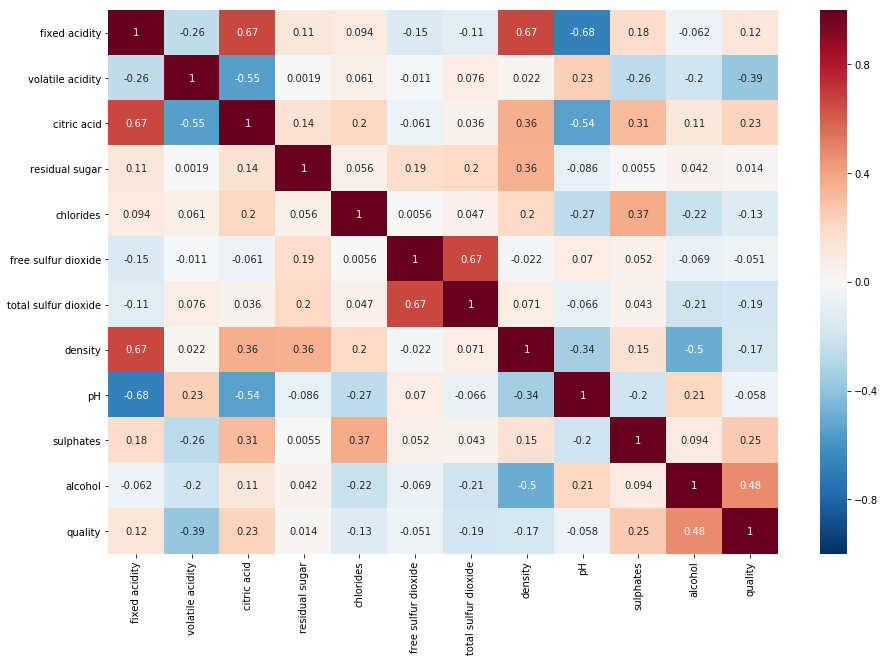

In [ ]:
plt.figure(figsize=(15,10))
corr = df.corr()
sns.heatmap(corr, cmap=sns.color_palette("RdBu_r", 1000), vmin=-1, center=0, annot=True)
plt.show()

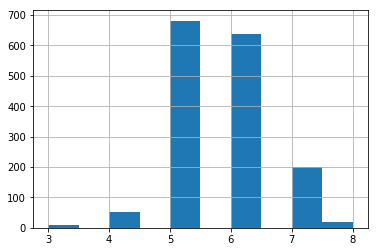

In [ ]:
df['quality'].hist()

In [ ]:
analyze(df)

Fixed Acidity
~~~~~~~~~~~~~~~~~~~~~~~~~

mean :  8.319637273295838
var  :  3.0295205688671296
skew :  0.9818292953262073
kurt :  1.1248563352037486
shapiro :  (0.942030668258667, 1.5255951637239901e-24)
normaltest :  NormaltestResult(statistic=224.53087840457746, pvalue=1.7528277735470436e-49)
~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~

Volatile Acidity
~~~~~~~~~~~~~~~~~~~~~~~~~

mean :  0.5278205128205131
var  :  0.03204232613332036
skew :  0.6709623963499574
kurt :  1.2179633893005306
shapiro :  (0.9743340611457825, 2.686806772838566e-16)
normaltest :  NormaltestResult(statistic=143.4193435598286, pvalue=7.192589039756692e-32)
~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~

Citric Acid
~~~~~~~~~~~~~~~~~~~~~~~~~

mean :  0.2709756097560964
var  :  0.037923751124940605
skew :  0.3180385895475358
kurt :  -0.7902825153036646
shapiro :  (0.9552900195121765, 1.0208196357632134e-21)
normaltest :  NormaltestResult(statistic=152.039214793795, pvalue=9.662822259281018e-34)
~~~~~~

In [ ]:
df['quality'].value_counts()

5    681
6    638
7    199
4     53
8     18
3     10
Name: quality, dtype: int64

In [ ]:
#Получаем таргет переменную и набор для обучения
x, y = unpack_X_and_y(df, 'quality')

In [ ]:
x.shape

(1599, 11)

In [ ]:
y.shape

(1599,)

In [ ]:
x.head(3)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,7.4,0.70,0.00,1.9,0.08,11.0,34.0,1.0,3.51,0.56,9.4
1,7.8,0.88,0.00,2.6,0.10,25.0,67.0,1.0,3.20,0.68,9.8
2,7.8,0.76,0.04,2.3,0.09,15.0,54.0,1.0,3.26,0.65,9.8


In [ ]:
# стандартизируем
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()
X = scaler.fit_transform(x)

In [ ]:
X.shape

(1599, 11)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=37)
sm = SMOTE()
X_train, y_train = sm.fit_sample(X_train, y_train)

In [ ]:
X_train.shape

(3276, 11)

In [ ]:
X_test.shape

(320, 11)

In [ ]:
y_train.shape

(3276,)

In [ ]:
y_test.shape

(320,)

## Boost

In [ ]:
model = XGBClassifier()
eval_set = [(X_test, y_test)]
model.fit(X_train, y_train, early_stopping_rounds=100, eval_set=eval_set, verbose=False)

y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

accuracy = metrics.accuracy_score(y_test, predictions)
print('Accuracy test: %.2f%%' % (accuracy * 100.0))
y_pred_train = model.predict(X_train)
predictions_train = [round(value) for value in y_pred_train]

accuracy = metrics.accuracy_score(y_train, predictions_train)
print('Accuracy train: %.2f%%' % (accuracy * 100.0))


Accuracy test: 58.75%
Accuracy train: 87.24%


In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import linear_model

In [ ]:
params = {
    'n_estimators': 1,
    'max_depth': 1,
    'learning_rate': 1
}

gradient_boosting_regressor = GradientBoostingRegressor(**params)

gradient_boosting_regressor.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=1, loss='ls', max_depth=1,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=1,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [ ]:
y_pred = gradient_boosting_regressor.predict(X_test)
predictions = [round(value) for value in y_pred]

accuracy = metrics.accuracy_score(y_test, predictions)
print('Accuracy test: %.2f%%' % (accuracy * 100.0))
y_pred_train = gradient_boosting_regressor.predict(X_train)
predictions_train = [round(value) for value in y_pred_train]

accuracy = metrics.accuracy_score(y_train, predictions_train)
print('Accuracy train: %.2f%%' % (accuracy * 100.0))

Accuracy test: 12.81%
Accuracy train: 28.27%


## Еще один вариант

In [ ]:
import xgboost as xgb
from sklearn import metrics


model = xgb.XGBClassifier()
param_dist = {"max_depth": [10,30,50],
              "min_child_weight" : [1,3,6],
              "n_estimators": [200],
              "learning_rate": [0.05, 0.1,0.16],}
model = GridSearchCV(model, param_grid=param_dist, cv = 5, 
                                   verbose=10, n_jobs=-1)
model.fit(X_train, y_train)


In [ ]:
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

accuracy = metrics.accuracy_score(y_test, predictions)
print('Accuracy test: %.2f%%' % (accuracy * 100.0))
y_pred_train = model.predict(X_train)
predictions_train = [round(value) for value in y_pred_train]

accuracy = metrics.accuracy_score(y_train, predictions_train)
print('Accuracy train: %.2f%%' % (accuracy * 100.0))

In [ ]:
import lightgbm as lgb
from sklearn import metrics


lg = lgb.LGBMClassifier(silent=False)
param_dist = {"max_depth": [25,50, 75],
              "learning_rate" : [0.01,0.05,0.1],
              "num_leaves": [300,900,1200],
              "n_estimators": [200]
             }
model2 = GridSearchCV(lg, n_jobs=-1, param_grid=param_dist, cv = 5, verbose=5)
model2.fit(X_train,y_train)


In [ ]:
y_pred = model2.predict(X_test)
predictions = [round(value) for value in y_pred]

accuracy = metrics.accuracy_score(y_test, predictions)
print('Accuracy test: %.2f%%' % (accuracy * 100.0))
y_pred_train = model2.predict(X_train)
predictions_train = [round(value) for value in y_pred_train]

accuracy = metrics.accuracy_score(y_train, predictions_train)
print('Accuracy train: %.2f%%' % (accuracy * 100.0))

In [ ]:
!pip install catboost

     |████████████████████████████████| 62.2MB 34.6MB/s 


In [ ]:
import catboost as cb

params = {'depth': [4, 7, 10],
          'learning_rate' : [0.03, 0.1, 0.15],
         'l2_leaf_reg': [1,4,9],
         'iterations': [300]}
cb = cb.CatBoostClassifier()
cb_model = GridSearchCV(cb, params, cv = 5)
cb_model.fit(X_train, y_train)

0:	learn: 1.7546705	total: 54.7ms	remaining: 16.3s
1:	learn: 1.7234536	total: 61.1ms	remaining: 9.11s
2:	learn: 1.6905578	total: 67.6ms	remaining: 6.69s
3:	learn: 1.6594061	total: 74.2ms	remaining: 5.49s
4:	learn: 1.6320454	total: 80.5ms	remaining: 4.75s
5:	learn: 1.6065161	total: 86.9ms	remaining: 4.26s
6:	learn: 1.5818675	total: 93.2ms	remaining: 3.9s
7:	learn: 1.5593732	total: 99.5ms	remaining: 3.63s
8:	learn: 1.5377106	total: 106ms	remaining: 3.42s
9:	learn: 1.5160920	total: 113ms	remaining: 3.27s
10:	learn: 1.4969727	total: 119ms	remaining: 3.14s
11:	learn: 1.4801986	total: 126ms	remaining: 3.03s
12:	learn: 1.4610642	total: 133ms	remaining: 2.94s
13:	learn: 1.4432571	total: 140ms	remaining: 2.85s
14:	learn: 1.4255091	total: 146ms	remaining: 2.78s
15:	learn: 1.4093711	total: 153ms	remaining: 2.71s
16:	learn: 1.3939811	total: 159ms	remaining: 2.64s
17:	learn: 1.3783711	total: 165ms	remaining: 2.58s
18:	learn: 1.3632768	total: 171ms	remaining: 2.53s
19:	learn: 1.3496626	total: 178ms	

KeyboardInterrupt: ignored

In [ ]:
y_pred = cb_model.predict(X_test)
predictions = [round(value) for value in y_pred]

accuracy = metrics.accuracy_score(y_test, predictions)
print('Accuracy test: %.2f%%' % (accuracy * 100.0))
y_pred_train = cb_model.predict(X_train)
predictions_train = [round(value) for value in y_pred_train]

accuracy = metrics.accuracy_score(y_train, predictions_train)
print('Accuracy train: %.2f%%' % (accuracy * 100.0))